# Описание данных для сравнения объявлений

**Целевая переменная:** `is_double` (флаг дубля объявлений)

*(где `*` = `base`/`cand`)*

## Группы признаков

### Идентификаторы
- `*_item_id` (str) - ID объявлений  
- `group_id` (int) - группа пользователей  
- `action_date` (datetime) - дата взаимодействия

### Категории
- `*_category_name` (str) - категория  
- `*_subcategory_name` (str) - подкатегория  
- `*_param1`, `*_param2` (str) - детализация  

### Контент
- `*_title`, `*_description` (str) - текст  
- `*_price` (float) - цена  
- `*_count_images` (int) - кол-во фото  
- `*_title_image` (str) - ID главного фото  
- `*_json_params` (json) - атрибуты в JSON

### Гео
- `is_same_location` (bool) - совпадение города  
- `is_same_region` (bool) - совпадение региона

### Таргет
- `is_double` (bool) - дубль объявлений

# Распаковка тренировочных данных (ТЕКСТ)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


In [ ]:
base_dir = '../data/raw/train/text/'
file_template = 'train_part_{}.snappy.parquet'
NUM_OF_FILES_PREPROC = 1

# Проверяем существование директории
if not os.path.exists(base_dir):
    print(f"Директория не найдена: {os.path.abspath(base_dir)}")
else:
    all_files_exist = all(os.path.exists(base_dir + file_template.format(f"{i:04d}")) for i in range(1, NUM_OF_FILES_PREPROC+1))
    
    if all_files_exist:
        # Загружаем все файлы если они существуют
        train_dfs = [pd.read_parquet(base_dir + file_template.format(f"{i:04d}")) for i in range(1, NUM_OF_FILES_PREPROC+1)]
        train_df = pd.concat(train_dfs, ignore_index=True)
        print("Все файлы успешно загружены!")
    else:
        print("Некоторые файлы отсутствуют:")
        for i in range(1, NUM_OF_FILES_PREPROC+1): 
            file_path = base_dir + file_template.format(f"{i:04d}")
            if not os.path.exists(file_path):
                print(f"- Отсутствует: {file_path}")

Все файлы успешно загружены!


In [34]:
train_df.shape

(500000, 27)

In [40]:
missing_values = train_df.isnull().sum()
missing_info = pd.DataFrame({
    'Количество пропусков': missing_values[missing_values > 0],
    'Тип данных': [train_df[col].dtype for col in missing_values[missing_values > 0].index]
})

print("\nИнформация о пропущенных значениях:")
print(missing_info)


Информация о пропущенных значениях:
                       Количество пропусков Тип данных
base_category_name                        3     object
base_subcategory_name                     3     object
base_param1                           19628     object
cand_param1                           19914     object
base_param2                          157666     object
cand_param2                          158232     object
base_count_images                      9553    float64
cand_count_images                      9351    float64


## Устранение пропусков

In [43]:
# Замена пропущенных значений в числовых столбцах на 0.0
numeric_columns = ['base_count_images', 'cand_count_images']
train_df[numeric_columns] = train_df[numeric_columns].fillna(0.0)

# Замена пропущенных значений в строковых столбцах на " "
object_columns = ['base_category_name', 'base_subcategory_name', 
                  'base_param1', 'cand_param1', 'base_param2', 'cand_param2']
train_df[object_columns] = train_df[object_columns].fillna(" ")

In [44]:
# Проверяем оставшиеся нулевые значения
print("Осталось пропусков после очистки:")
print(train_df.isnull().sum()[train_df.isnull().sum() > 0])

Осталось пропусков после очистки:
Series([], dtype: int64)


In [46]:
train_df.shape

(500000, 27)

Target distribution:
 is_double
0    0.938822
1    0.061178
Name: proportion, dtype: float64


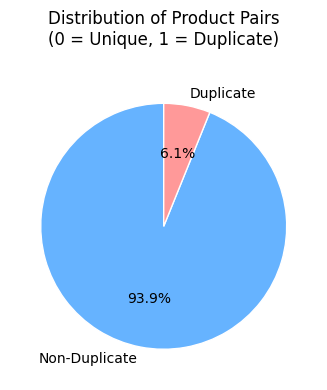

In [50]:
import matplotlib.pyplot as plt

# Target distribution
target_dist = train_df['is_double'].value_counts(normalize=True)
print("Target distribution:\n", target_dist)

# Create pie plot
plt.figure(figsize=(4, 4))
plt.pie(
    target_dist,
    labels=['Non-Duplicate', 'Duplicate'], 
    autopct='%.1f%%',
    startangle=90,
    colors=['#66b3ff', '#ff9999'], 
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
)

# Add title and make it look clean
plt.title('Distribution of Product Pairs\n(0 = Unique, 1 = Duplicate)', pad=20)
plt.tight_layout()
plt.show()

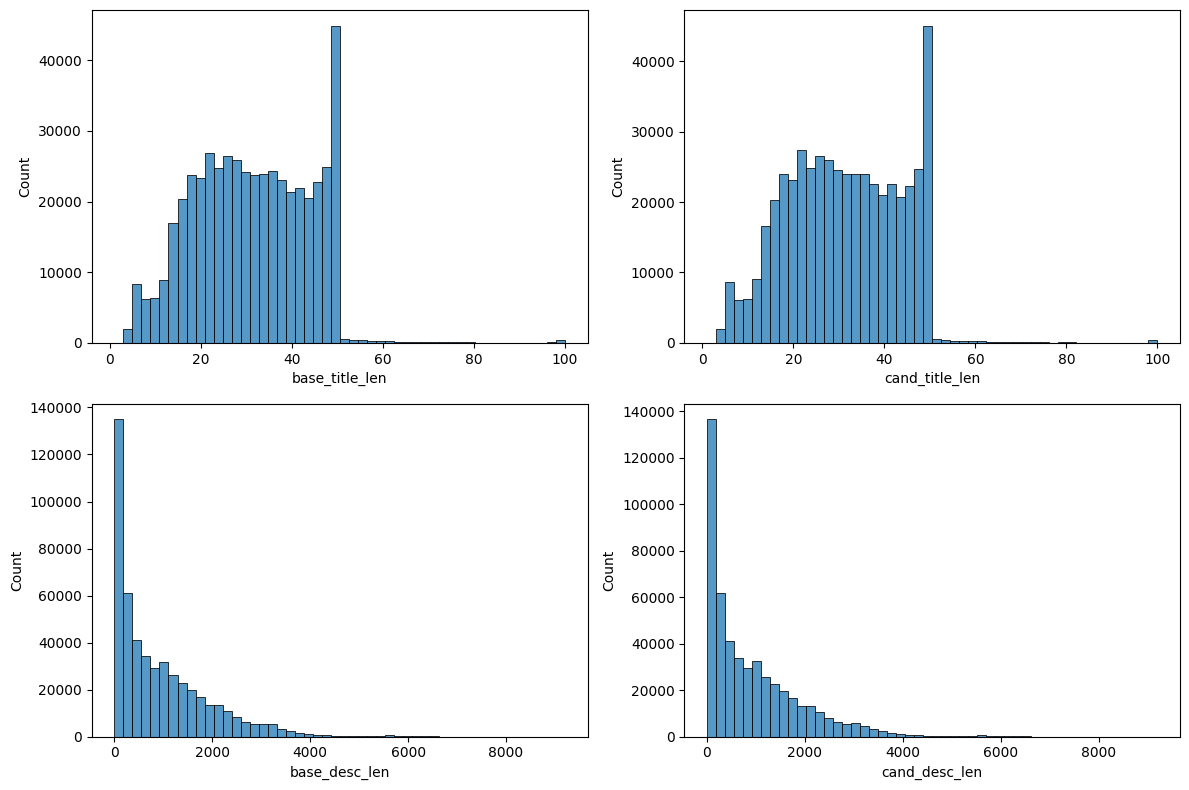


Missing titles:
 base_title    0
cand_title    0
dtype: int64

Missing descriptions:
 base_description    0
cand_description    0
dtype: int64


In [51]:
# Text length analysis
train_df['base_title_len'] = train_df['base_title'].str.len()
train_df['cand_title_len'] = train_df['cand_title'].str.len()
train_df['base_desc_len'] = train_df['base_description'].str.len()
train_df['cand_desc_len'] = train_df['cand_description'].str.len()

# Plot distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(train_df['base_title_len'], ax=axes[0, 0], bins=50)
sns.histplot(train_df['cand_title_len'], ax=axes[0, 1], bins=50)
sns.histplot(train_df['base_desc_len'], ax=axes[1, 0], bins=50)
sns.histplot(train_df['cand_desc_len'], ax=axes[1, 1], bins=50)
plt.tight_layout()
plt.show()

# Missing text analysis
print("\nMissing titles:\n", train_df[['base_title', 'cand_title']].isnull().sum())
print("\nMissing descriptions:\n", train_df[['base_description', 'cand_description']].isnull().sum())

In [52]:
# Sample a subset for initial analysis (for performance)
sample_df = train_df.sample(n=10000, random_state=42)

# Calculate basic similarity metrics
def jaccard_similarity(text1, text2):
    a = set(text1.lower().split()) 
    b = set(text2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

sample_df['title_jaccard'] = sample_df.apply(
    lambda x: jaccard_similarity(x['base_title'], x['cand_title']), axis=1)

# TF-IDF similarity
tfidf = TfidfVectorizer(stop_words='english')
title_pairs = pd.concat([
    sample_df['base_title'],
    sample_df['cand_title']
], axis=0).fillna("")

tfidf_matrix = tfidf.fit_transform(title_pairs)
cos_sim = cosine_similarity(tfidf_matrix[:len(sample_df)], tfidf_matrix[len(sample_df):])
sample_df['title_cosine'] = np.diag(cos_sim)

# Analyze similarity by target
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='is_double', y='title_jaccard', data=sample_df)
plt.subplot(1, 2, 2)
sns.boxplot(x='is_double', y='title_cosine', data=sample_df)
plt.tight_layout()
plt.show()

NameError: name 'TfidfVectorizer' is not defined